In [11]:
import os
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, IDF, VectorAssembler
from pyspark.sql.functions import regexp_replace, lower, col
from pyspark.ml.feature import HashingTF
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql.functions import hour, dayofweek, month, year, weekofyear
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier




# load data

In [2]:


data = []

# Loop through all files in the Spark_test folder
for foldername, subfolders, filenames in os.walk('/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories'):
    for filename in filenames:
        # Check if the file is a .file and starts with 'part-'
        if filename.startswith('part-'):
            filepath = os.path.join(foldername, filename)
            print(filepath)
            # Open the file and parse each line as a JSON object
            with open(filepath, 'r') as f:
                for line in f:
                    obj = json.loads(line)
                    # Extract the required fields and append to the data list
                    data.append({
                        'aid': obj['aid'],
                        'title': obj['title'],
                        'url': obj['url'],
                        'domain': obj['domain'],
                        'user': obj['user'],
                        'posted_at': obj['posted_at'],
                        'comments': obj['comments'],
                        'source_title': obj['source_title'],
                        'source_text': obj['source_text'],
                        'frontpage': obj['frontpage'],
                    })



/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00017
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00028
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00010
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00026
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00019
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/part-00021
/Users/camillecu/Downloads/KUL/AdvancedAnalytic/AdvancedAnalytics_Assignments/assignment 3/saved-stories/saved_stories-1715625960000/par

In [4]:
# Convert the data list to a PySpark DataFrame
spark = SparkSession.builder.appName('reddit').getOrCreate()
df = spark.createDataFrame(data)

24/05/26 21:53:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [12]:

# Initialize Spark session
spark = SparkSession.builder.appName('preprocessing_pipeline').getOrCreate()

# Sample DataFrame
# df = spark.read.csv('path_to_your_csv', header=True, inferSchema=True)

# Define preprocessing functions
def preprocess_column(df, column):
    return df.withColumn(column, lower(regexp_replace(column, '[^\\sa-zA-Z0-9]', ''))).fillna('null')

df = preprocess_column(df, 'title')
df = preprocess_column(df, 'source_title')
df = preprocess_column(df, 'source_text')
df = preprocess_column(df, 'user')

# Convert 'frontpage' to binary and 'posted_at' to timestamp
df = df.withColumn('frontpage', df['frontpage'].cast('int'))
df = df.withColumn('posted_at', df['posted_at'].cast('timestamp'))

# Define the stages of the pipeline
stages = []

# Tokenize, remove stop words, apply CountVectorizer, and IDF for text columns
text_columns = ['title', 'source_title', 'source_text']
for col in text_columns:
    tokenizer = Tokenizer(inputCol=col, outputCol=col + '_words')
    stop_words_remover = StopWordsRemover(inputCol=col + '_words', outputCol=col + '_filtered_words')
    cv = CountVectorizer(inputCol=col + '_filtered_words', outputCol=col + '_features', vocabSize=1000)
    idf = IDF(inputCol=col + '_features', outputCol=col + '_tfidf_features')
    stages += [tokenizer, stop_words_remover, cv, idf]

# Process categorical columns with StringIndexer
categorical_cols = ['domain', 'user']
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + '_indexed', handleInvalid='skip')
    stages += [indexer]

# Process timestamp column
df = df.withColumn('posted_at_hour', hour(df['posted_at']))
df = df.withColumn('posted_at_dayofweek', dayofweek(df['posted_at']))
df = df.withColumn('posted_at_month', month(df['posted_at']))
df = df.withColumn('posted_at_year', year(df['posted_at']))

# Combine features into a single vector column
assembler = VectorAssembler(
    inputCols=[
        'comments',
        'title_tfidf_features',
        'source_title_tfidf_features',
        'source_text_tfidf_features',
        'domain_indexed',
        'user_indexed',
        'posted_at_hour',
        'posted_at_dayofweek',
        'posted_at_month',
        'posted_at_year'
    ],
    outputCol='features'
)
stages += [assembler]

# Apply ChiSqSelector to select top features
selector = ChiSqSelector(
    numTopFeatures=3,
    featuresCol="features",
    outputCol="selectedFeatures",
    labelCol="frontpage"
)
stages += [selector]

# Add a classifier
classifier = RandomForestClassifier(featuresCol='selectedFeatures', labelCol='frontpage')
stages += [classifier]

# Create and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df)

# Save the pipeline model
pipeline_model.save("pipeline_model")

# Load and use the pipeline model
# loaded_pipeline_model = PipelineModel.load("path_to_save_your_model/pipeline_model")
# predictions = loaded_pipeline_model.transform(new_data)


24/05/26 21:55:34 WARN StopWordsRemover: Default locale set was [en_CN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/26 21:55:34 WARN StopWordsRemover: Default locale set was [en_CN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/26 21:55:34 WARN StopWordsRemover: Default locale set was [en_CN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
24/05/26 21:55:37 WARN TaskSetManager: Stage 0 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/26 21:55:44 WARN TaskSetManager: Stage 4 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/26 21:55:48 WARN TaskSetManager: Stage 6 contains a task of very large si

In [62]:
# map the selected features to the original feature names

selected_indices = selector_model.selectedFeatures

# Print the selected features
print("Selected feature indices: ", selected_indices)

selected_features = selector_model.selectedFeatures
feature_names = [
    'comments',
    'source_title_tfidf_features',
    'title_tfidf_features',
    'source_text_tfidf_features',
    'combined_tfidf_features',
    'domain_indexed',
    'user_indexed',
    'posted_at_hour',
    'posted_at_dayofweek',
    'posted_at_month',
    'posted_at_year'
]
# Flatten the feature names to match the indices
flattened_feature_names = []
for name in feature_names:
    if 'tfidf_features' in name:
        # Assuming each TF-IDF feature is a vector of 1000 elements
        flattened_feature_names.extend([name + f"_{i}" for i in range(10000)])
    else:
        flattened_feature_names.append(name)

# Map selected indices back to the original feature names
selected_feature_names = [flattened_feature_names[i] for i in selected_indices]

# Print the selected feature names
print("Selected feature names: ", selected_feature_names)

# Show the result
# result.show(truncate=False)


Selected feature indices:  [0, 2133, 2413]
Selected feature names:  ['comments', 'source_title_tfidf_features_2132', 'source_title_tfidf_features_2412']


# Train M

## Gradient-boosted tree classifier

In [63]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a GBT model.
gbt = GBTClassifier(labelCol="frontpage", featuresCol="selectedFeatures", maxIter=10)
# Train model
model = gbt.fit(train_selected)
# Make predictions.
predictions = model.transform(test_selected)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print('accuracy is:', accuracy)


24/05/25 21:04:39 WARN TaskSetManager: Stage 191 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:04:40 WARN TaskSetManager: Stage 192 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:04:47 WARN TaskSetManager: Stage 193 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:04:53 WARN TaskSetManager: Stage 195 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:00 WARN TaskSetManager: Stage 197 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:00 WARN TaskSetManager: Stage 199 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:00 WARN TaskSetManager: Stage 201 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.

accuracy is: 0.8165374677002584


In [64]:
# Confusion matrix
y_true = predictions.select(['frontpage']).collect()
y_pred = predictions.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)



24/05/25 21:05:14 WARN TaskSetManager: Stage 297 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:19 WARN TaskSetManager: Stage 298 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


array([[287,   4],
       [ 67,  29]])

24/05/25 21:05:25 WARN TaskSetManager: Stage 299 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


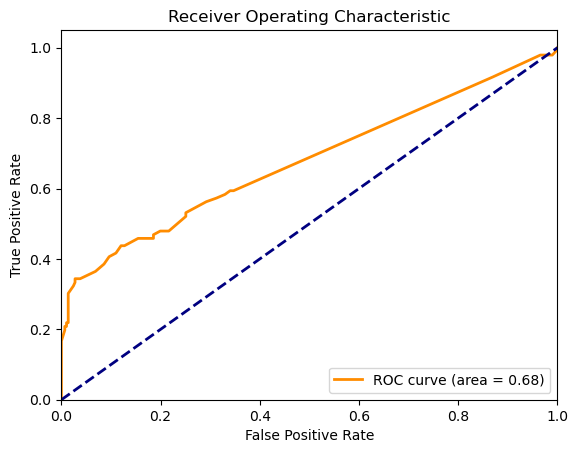

In [65]:
# ROC curve
y_prob = predictions.select(['probability']).collect()
y_prob = np.array([x[0][1] for x in y_prob])
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression - combined text features

In [66]:
lr = LogisticRegression(labelCol="frontpage", featuresCol="selectedFeatures")
lrModel = lr.fit(train_selected)
predictions = lrModel.transform(test_selected)
# predictions.show()
# predictions.select('probability', 'frontpage', 'prediction').show(truncate=False)

24/05/25 21:05:30 WARN TaskSetManager: Stage 300 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:38 WARN TaskSetManager: Stage 302 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:46 WARN TaskSetManager: Stage 304 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:46 WARN TaskSetManager: Stage 306 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:46 WARN TaskSetManager: Stage 308 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:47 WARN TaskSetManager: Stage 310 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:05:47 WARN TaskSetManager: Stage 312 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.

24/05/25 21:05:50 WARN TaskSetManager: Stage 328 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


AUC:  0.6770117411225658


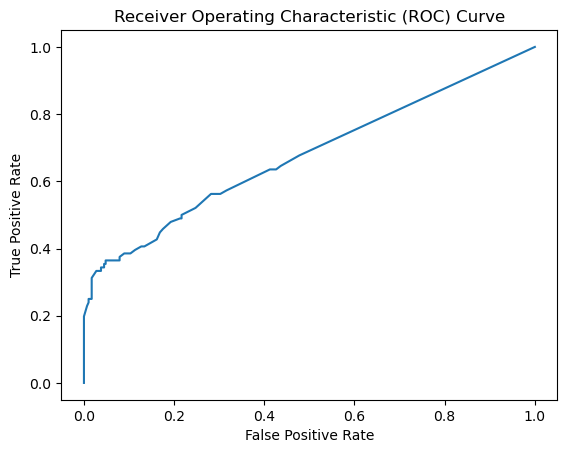

In [67]:
pandas_df = predictions.select('frontpage','probability','prediction').toPandas()
labels = pandas_df['frontpage']
predicted = pandas_df['prediction']
probabilities = pandas_df['probability'].apply(lambda x: x[1])


# AUC/ROC
fpr, tpr, thresholds = roc_curve(labels, probabilities)
plt.plot(fpr, tpr)
auc = roc_auc_score(labels, probabilities)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
print('AUC: ', auc)

In [68]:
# Confusion matrix and accuracy
cm = confusion_matrix(labels, predicted)

print(cm)
accuracy = accuracy_score(labels, predicted)
print('accuracy: ', accuracy)


[[286   5]
 [ 72  24]]
accuracy:  0.8010335917312662


## random forest

In [69]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [70]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="frontpage", featuresCol="selectedFeatures")

# Train model. 
model = dt.fit(train_selected)

# Make predictions.
predictions = model.transform(test_selected)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="frontpage", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("accuracy = %g " % (accuracy))

24/05/25 21:05:56 WARN TaskSetManager: Stage 329 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:00 WARN TaskSetManager: Stage 332 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:01 WARN TaskSetManager: Stage 333 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:08 WARN TaskSetManager: Stage 334 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:17 WARN TaskSetManager: Stage 336 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:25 WARN TaskSetManager: Stage 338 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:25 WARN TaskSetManager: Stage 340 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.

accuracy = 0.806202 


24/05/25 21:06:30 WARN TaskSetManager: Stage 348 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:34 WARN TaskSetManager: Stage 349 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.
24/05/25 21:06:39 WARN TaskSetManager: Stage 350 contains a task of very large size (6986 KiB). The maximum recommended task size is 1000 KiB.


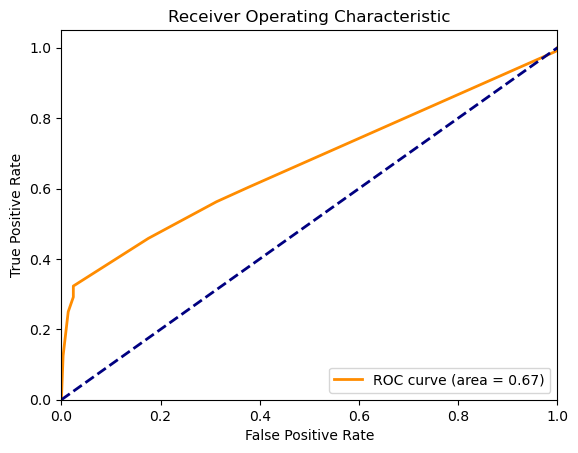

In [71]:
# Confusion matrix
y_true = predictions.select(['frontpage']).collect()
y_pred = predictions.select(['prediction']).collect()
confusion_matrix(y_true, y_pred)

# ROC curve
y_prob = predictions.select(['probability']).collect()
y_prob = np.array([x[0][1] for x in y_prob])
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
